In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andy8744/udacity-self-driving-car-behavioural-cloning")

print("Path to dataset files:", path)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 281M/281M [00:43<00:00, 6.72MB/s] 

Extracting files...


Path to dataset files: /Users/jasminele/.cache/kagglehub/datasets/andy8744/udacity-self-driving-car-behavioural-cloning/versions/1


In [ ]:
import os
import kagglehub

# Download latest version if not already present
dataset_path = kagglehub.dataset_download("andy8744/udacity-self-driving-car-behavioural-cloning")

print("Dataset downloaded at:", dataset_path)

dataset_dir = os.path.join(dataset_path, "self_driving_car_dataset_make")

print("Final dataset path:", dataset_dir)

Dataset downloaded at: /Users/jasminele/.cache/kagglehub/datasets/andy8744/udacity-self-driving-car-behavioural-cloning/versions/1
Final dataset path: /Users/jasminele/.cache/kagglehub/datasets/andy8744/udacity-self-driving-car-behavioural-cloning/versions/1/self_driving_car_dataset_make


In [ ]:
import pandas as pd

df = pd.read_csv(os.path.join(dataset_dir, "driving_log.csv"))

print("Dataset loaded successfully!")

Dataset loaded successfully!


In [ ]:
# General libraries
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [16]:
# Define column names
column_names = ["centercam", "leftcam", "rightcam", "steering_angle", "throttle", "reverse", "speed"]

# Reload CSV with column names
df = pd.read_csv(os.path.join(dataset_dir, "driving_log.csv"), names=column_names)

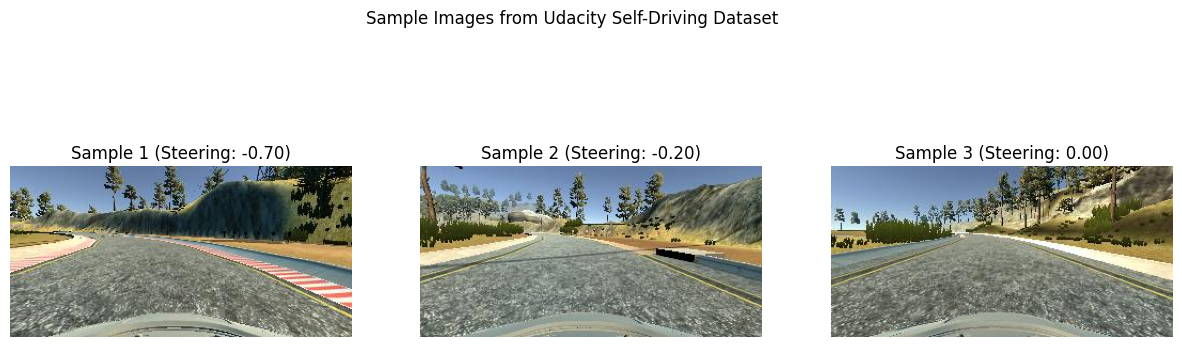

In [9]:
# Load and display sample images
sample_indices = [10, 100, 500]  
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, idx in enumerate(sample_indices):
    img_filename = os.path.basename(df.iloc[idx]["centercam"].replace("\\", "/"))
    img_path = os.path.join(dataset_dir, "IMG", img_filename)

    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        axes[i].imshow(img)
        axes[i].set_title(f"Sample {i+1} (Steering: {df.iloc[idx]['steering_angle']:.2f})")
        axes[i].axis("off")
    else:
        print(f"Error loading image: {img_path}")

plt.suptitle("Sample Images from Udacity Self-Driving Dataset")
plt.show()

In [11]:
class SelfDrivingDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None, seq_len=5):
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.transform = transform
        self.seq_len = seq_len

    def __len__(self):
        return max(0, len(self.dataframe) - self.seq_len)

    def __getitem__(self, idx):
        states, actions = [], []
        for i in range(self.seq_len):
            img_path = self.dataframe.iloc[idx + i]["centercam"]
            img_filename = os.path.basename(img_path.replace("\\", "/"))  
            img_path = os.path.join(self.data_dir, "IMG", img_filename)

            img = cv2.imread(img_path)
            if img is None:
                raise FileNotFoundError(f"Image not found: {img_path}")

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = np.array(img, dtype=np.uint8)

            if self.transform:
                img = self.transform(img)

            states.append(img)
            actions.append(self.dataframe.iloc[idx + i]["steering_angle"])

        states = torch.stack(states)  
        actions = torch.tensor(actions, dtype=torch.float32)

        reversed_actions = np.cumsum(actions.numpy()[::-1].copy())[::-1].copy()
        returns_to_go = torch.tensor(reversed_actions, dtype=torch.float32)

        return returns_to_go, states, actions

In [12]:
def get_dataloader(data_path, batch_size=32, seq_len=5):
    df = pd.read_csv(os.path.join(data_path, "driving_log.csv"), names=column_names)

    transform = transforms.Compose([
        transforms.ToPILImage(),  
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = SelfDrivingDataset(df, data_path, transform=transform, seq_len=seq_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load dataloader
dataloader = get_dataloader(dataset_dir, batch_size=32, seq_len=5)
print("DataLoader successfully created.")

DataLoader successfully created.


In [13]:
import torchvision.models as models

class DecisionTransformer(nn.Module):
    def __init__(self, state_dim=(3, 128, 128), action_dim=1, embed_dim=256, seq_len=5):
        super(DecisionTransformer, self).__init__()

        self.seq_len = seq_len
        self.action_dim = action_dim

        resnet = models.resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  
        self.resnet.eval()
        for param in self.resnet.parameters():
            param.requires_grad = False  

        with torch.no_grad():
            dummy_input = torch.randn(1, *state_dim)
            cnn_output_dim = self.resnet(dummy_input).view(-1).shape[0]

        self.state_embedding = nn.Linear(cnn_output_dim, embed_dim)
        self.action_embedding = nn.Linear(action_dim, embed_dim)
        self.return_embedding = nn.Linear(1, embed_dim)

        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=8,  
            num_encoder_layers=6, 
            num_decoder_layers=6,
            batch_first=True
        )

        self.action_head = nn.Linear(embed_dim, action_dim)

    def forward(self, returns, states, actions):
        batch_size = states.shape[0]

        states = states.view(batch_size * self.seq_len, *states.shape[2:])
        with torch.no_grad():
            states = self.resnet(states)
        states = states.view(batch_size, self.seq_len, -1)
        states = self.state_embedding(states)

        actions = self.action_embedding(actions.unsqueeze(-1))
        returns = self.return_embedding(returns.unsqueeze(-1))

        x = states + actions + returns  

        seq_mask = torch.triu(torch.ones(self.seq_len, self.seq_len), diagonal=1).bool().to(x.device)
        output = self.transformer(x, x, tgt_mask=seq_mask)

        predicted_action = self.action_head(output)  

        return predicted_action.squeeze(-1)

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DecisionTransformer().to(device)
print("Model initialized.")

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model initialized.


/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 - Loss: 0.0687, MAE: 0.2227, RMSE: 0.2692
Epoch 2/10 - Loss: 0.0137, MAE: 0.1129, RMSE: 0.1613
Epoch 3/10 - Loss: 0.0110, MAE: 0.0919, RMSE: 0.1445
Epoch 4/10 - Loss: 0.0077, MAE: 0.0789, RMSE: 0.1195
Epoch 5/10 - Loss: 0.0027, MAE: 0.0500, RMSE: 0.0706
Epoch 6/10 - Loss: 0.0013, MAE: 0.0366, RMSE: 0.0505
Epoch 7/10 - Loss: 0.0012, MAE: 0.0352, RMSE: 0.0487
Epoch 8/10 - Loss: 0.0012, MAE: 0.0343, RMSE: 0.0480
Epoch 9/10 - Loss: 0.0008, MAE: 0.0275, RMSE: 0.0388
Epoch 10/10 - Loss: 0.0008, MAE: 0.0284, RMSE: 0.0395


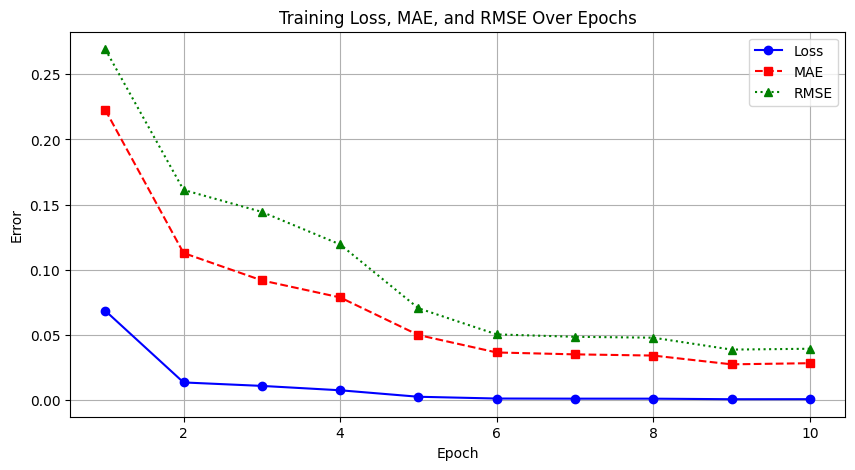

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from decision_transformer import DecisionTransformer
from dataset import get_dataloader

dataset_path = dataset_dir  

# Load Dataset
dataloader = get_dataloader(dataset_path, batch_size=32, seq_len=5) 

# Define Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DecisionTransformer().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-5)  
loss_fn = nn.SmoothL1Loss()  

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 10  
best_loss = float('inf')

# Logging Variables
losses, mae_values, rmse_values = [], [], []

# Data Augmentation Function
def augment_data(states, actions):
    if torch.rand(1) < 0.5:
        states = torch.flip(states, dims=[-1])  
        actions = -actions 
    actions += torch.randn_like(actions) * 0.01  
    return states, actions

# Training Loop
for epoch in range(num_epochs):
    total_loss, total_mae, total_rmse, num_samples = 0, 0, 0, 0

    for returns, states, actions in dataloader:
        returns, states, actions = returns.to(device), states.to(device), actions.to(device)

        # Apply Data Augmentation
        states, actions = augment_data(states, actions)

        optimizer.zero_grad()
        predicted_actions = model(returns, states, actions)
        loss = loss_fn(predicted_actions, actions)

        # Gradient Clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
        optimizer.step()

        total_loss += loss.item()
        errors = torch.abs(predicted_actions - actions)
        mae = errors.mean().item()
        rmse = torch.sqrt((errors**2).mean()).item()

        total_mae += mae * actions.size(0)
        total_rmse += rmse * actions.size(0)
        num_samples += actions.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_mae = total_mae / num_samples
    avg_rmse = total_rmse / num_samples

    losses.append(avg_loss)
    mae_values.append(avg_mae)
    rmse_values.append(avg_rmse)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, MAE: {avg_mae:.4f}, RMSE: {avg_rmse:.4f}")

    scheduler.step(avg_loss)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o', color='blue', linestyle='-', label="Loss")
plt.plot(range(1, len(mae_values) + 1), mae_values, marker='s', color='red', linestyle='--', label="MAE")
plt.plot(range(1, len(rmse_values) + 1), rmse_values, marker='^', color='green', linestyle=':', label="RMSE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training Loss, MAE, and RMSE Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


Mean Absolute Error (MAE): 0.0130
Root Mean Squared Error (RMSE): 0.0322
Percentage of Predictions Within ±5 Degrees: 95.17%


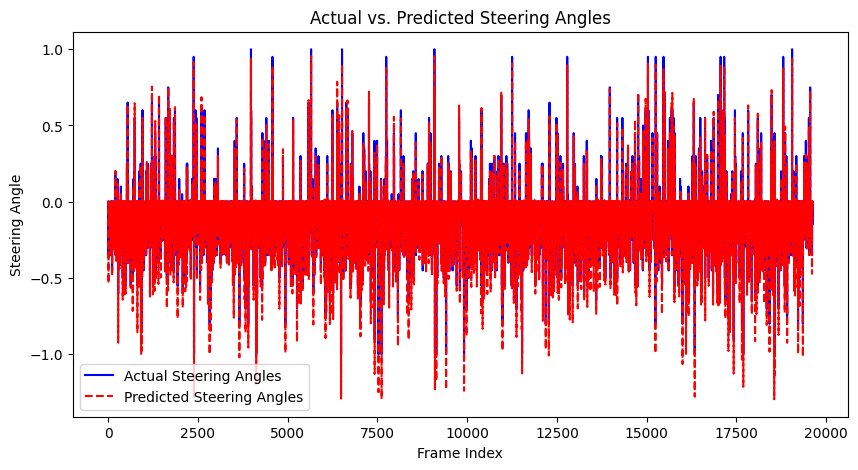

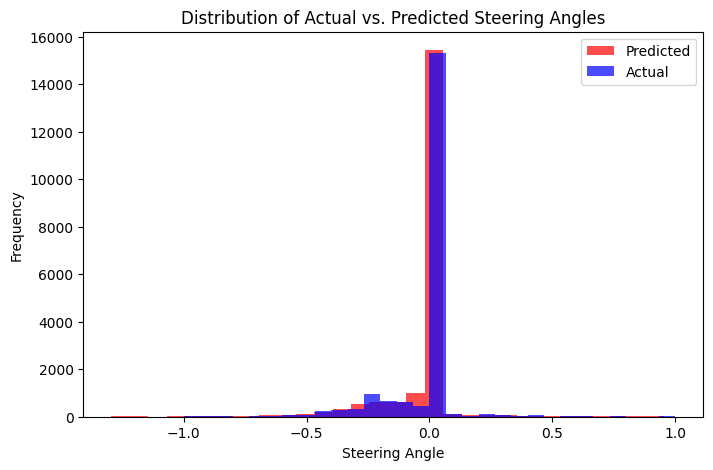

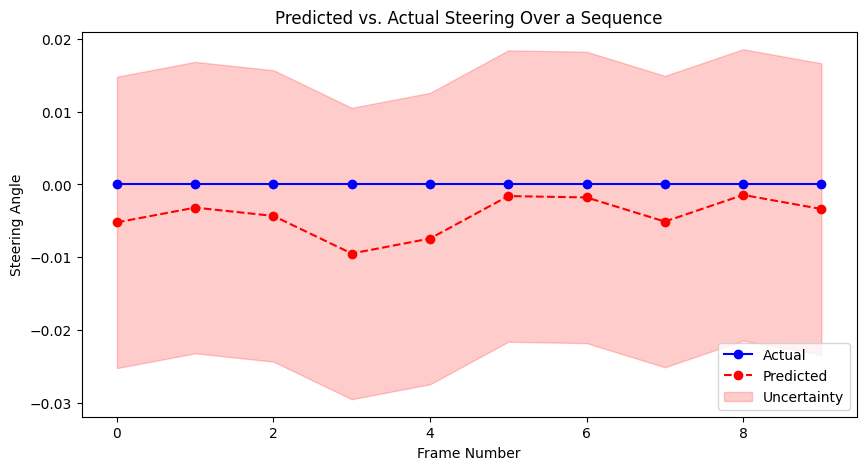

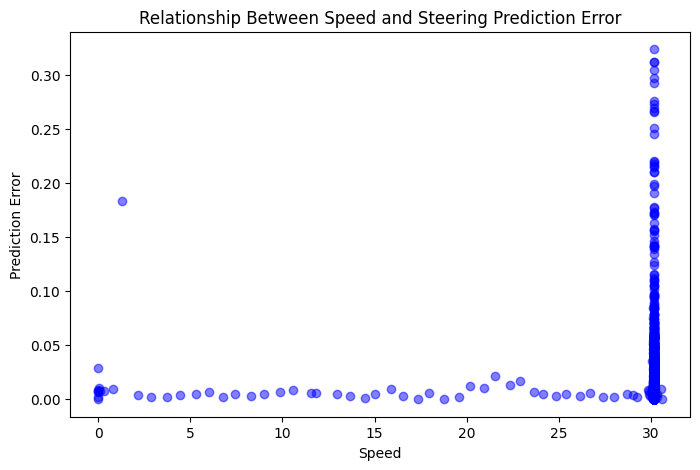

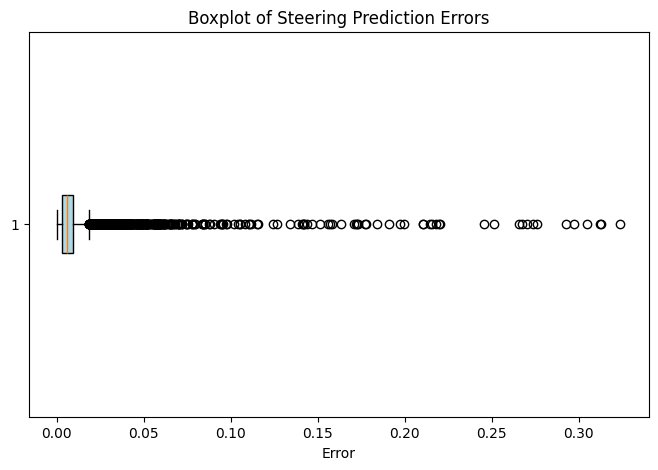

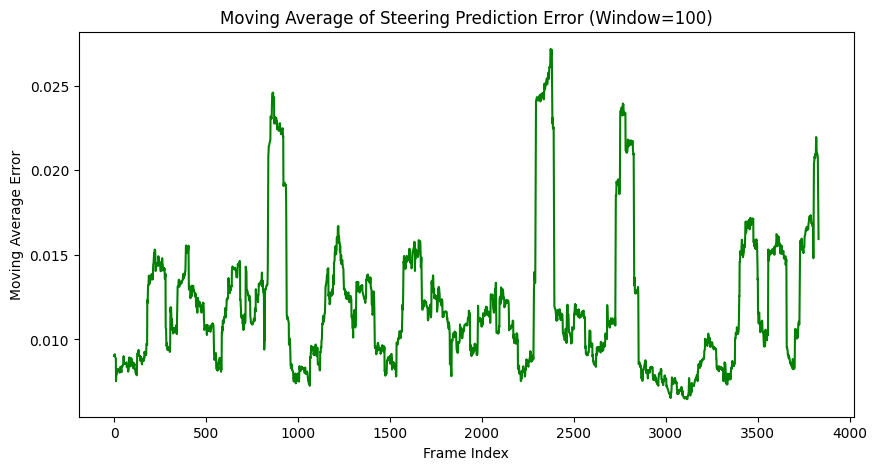

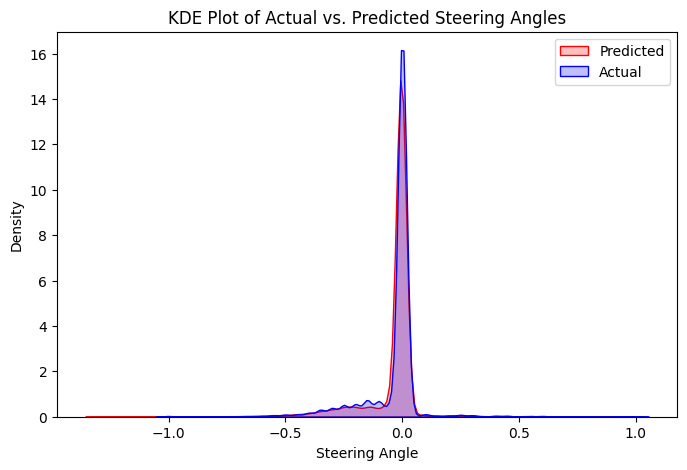

In [15]:
dataset_path = dataset_dir  

dataloader = get_dataloader(dataset_path, batch_size=1, seq_len=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval() 

actual_steering = []
predicted_steering = []

for returns, states, actions in dataloader:
    returns, states, actions = returns.to(device), states.to(device), actions.to(device)
    predicted_actions = model(returns, states, actions).detach().cpu().numpy()

    actual_steering.append(actions.squeeze().tolist())
    predicted_steering.append(predicted_actions.squeeze().tolist())

actual_steering = [item for sublist in actual_steering for item in sublist]
predicted_steering = [item for sublist in predicted_steering for item in sublist]

errors = np.abs(np.array(actual_steering) - np.array(predicted_steering))

# Metrics
mae = np.mean(errors)
rmse = np.sqrt(np.mean(errors**2))
within_5_degrees = np.mean(errors < 0.05) * 100  # Percentage within ±5 degrees

# Print evaluation results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Percentage of Predictions Within ±5 Degrees: {within_5_degrees:.2f}%")

# Plots
frame_indices = np.arange(len(errors))  # Frame indices for plotting

# 1. Actual vs. Predicted Steering Angles
plt.figure(figsize=(10, 5))
plt.plot(actual_steering, label="Actual Steering Angles", color="blue")
plt.plot(predicted_steering, label="Predicted Steering Angles", color="red", linestyle="dashed")
plt.xlabel("Frame Index")
plt.ylabel("Steering Angle")
plt.legend()
plt.title("Actual vs. Predicted Steering Angles")
plt.show()

# 2. Histogram of Steering Predictions
plt.figure(figsize=(8, 5))
plt.hist(predicted_steering, bins=30, alpha=0.7, label="Predicted", color="red")
plt.hist(actual_steering, bins=30, alpha=0.7, label="Actual", color="blue")
plt.xlabel("Steering Angle")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Steering Angles")
plt.show()

# 3. Predicted vs. Actual Steering Over a Sequence
sample_index = np.random.randint(0, len(actual_steering) - 10)

plt.figure(figsize=(10, 5))
plt.plot(range(10), actual_steering[sample_index:sample_index + 10], label="Actual", marker='o', color="blue")
plt.plot(range(10), predicted_steering[sample_index:sample_index + 10], label="Predicted", marker='o', color="red", linestyle="dashed")
plt.fill_between(range(10),
    np.array(predicted_steering[sample_index:sample_index + 10]) - 0.02,  
    np.array(predicted_steering[sample_index:sample_index + 10]) + 0.02,
    color='red', alpha=0.2, label="Uncertainty")
plt.xlabel("Frame Number")
plt.ylabel("Steering Angle")
plt.legend()
plt.title("Predicted vs. Actual Steering Over a Sequence")
plt.show()

# 4. Speed vs. Steering Prediction Error
csv_path = os.path.join(dataset_path, "driving_log.csv")
df = pd.read_csv(csv_path, names=["centercam", "leftcam", "rightcam", "steering_angle", "throttle", "reverse", "speed"])

min_length = min(len(errors), len(df["speed"]))

speeds = df["speed"].values[:min_length]
errors = errors[:min_length] 

plt.figure(figsize=(8, 5))
plt.scatter(speeds, errors, alpha=0.5, color="blue")
plt.xlabel("Speed")
plt.ylabel("Prediction Error")
plt.title("Relationship Between Speed and Steering Prediction Error")
plt.show()

# 5. Boxplot of Steering Prediction Errors
plt.figure(figsize=(8, 5))
plt.boxplot(errors, vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.xlabel("Error")
plt.title("Boxplot of Steering Prediction Errors")
plt.show()

# 6. Average Error Over Time (Moving Average)
window_size = 100  
moving_avg_error = np.convolve(errors, np.ones(window_size) / window_size, mode="valid")

plt.figure(figsize=(10, 5))
plt.plot(moving_avg_error, color="green")
plt.xlabel("Frame Index")
plt.ylabel("Moving Average Error")
plt.title(f"Moving Average of Steering Prediction Error (Window={window_size})")
plt.show()

# 7. Kernel Density Estimate (KDE) Plot
plt.figure(figsize=(8, 5))
sns.kdeplot(predicted_steering, label="Predicted", color="red", fill=True)
sns.kdeplot(actual_steering, label="Actual", color="blue", fill=True)
plt.xlabel("Steering Angle")
plt.ylabel("Density")
plt.legend()
plt.title("KDE Plot of Actual vs. Predicted Steering Angles")
plt.show()